In [10]:
from __future__ import print_function, division
from exosyspop.populations import KeplerPowerLawBinaryPopulation
from exosyspop.survey import DetectionRamp

import logging
rootLogger = logging.getLogger()
rootLogger.setLevel(logging.INFO)

In [26]:
import sys
sys.path.append('..')

from simpleabc.simple_abc import Model, basic_abc, pmc_abc

import numpy as np
from scipy.stats import gaussian_kde, entropy, uniform
import logging

class ABCModel(Model):

    params = ('fB', 'beta', 'beta_a', 'beta_b') # Names of parameters
    summary_stat_names = ('period_pdf','N',
                          'phase_sec') # names of summary statistics
    distance_functions = ('d_period', 'd_N',
                          'd_fsec', 'd_phase') # names of different distance function methods 

    theta_0 = (0.14, -0.95, 0.8, 2.0)
    bounds = [(0,1), (-1.5,0), (0,5),(0,5)]
    prior = [uniform(0,1), uniform(-1.5, 1.5), uniform(0,5), uniform(0,5)]    
    
    
    def __init__(self, population, eff=None):
        self.population = population
        self.eff = eff

    def draw_theta(self):
        return [p.rvs() for p in self.prior]
        #theta = []
        #for p,(lo,hi) in zip(self.priors, self.bounds):
        #    if p=='uniform':
        #        theta.append(np.random.random()*(hi-lo) + lo)
        #return theta

    def generate_data(self, theta):
        param_dict = {p:v for p,v in zip(self.params, theta)}
        self.population.set_params(**param_dict)
        try:
            return self.population.observe(new=True, regr_trap=True).observe(self.eff)
        except KeyboardInterrupt:
            raise
        except:
            logging.warning('Error generating data: {}'.format(param_dict))

    @property
    def min_period(self):
        return self.population.params['period_min']
    
    @property
    def max_period(self):
        return self.population.params['period_max']

    def summary_stats(self, data):
        """Returns tuple containing summary statistics named in summary_stat_names
        """
        if data is None:
            return [None]*len(self.summary_stat_names)

        N = len(data)
        min_logP, max_logP = np.log(self.min_period), np.log(self.max_period)
        logP_grid = np.linspace(min_logP, max_logP, 1000)
        if N > 1:
            k = gaussian_kde(np.log(data.period.values))
            logP_pdf = k(logP_grid)
        else:
            logP_pdf = np.ones(len(logP_grid))*1./(max_logP - min_logP)

        phase_sec = data.phase_sec.dropna().values
            
        return logP_pdf, N, phase_sec

    def d_period(self, summary_stats, summary_stats_synth):
        p1 = summary_stats[0]
        p2 = summary_stats_synth[0]
        try:
            len(p1)
            len(p2)
        except:
            return np.inf
        kl_period = entropy(p1, p2)
        return kl_period
    
    def Ndist(self, N1, N2):
        if N1==0. or N2==0. or N1 is None or N2 is None:
            dist = 1
        else:
            dist = max(1 - 1.*N1/N2, 1-1*N2/N1)
        return dist
            
    def d_N(self, summary_stats, summary_stats_synth):
        N1 = summary_stats[1]
        N2 = summary_stats_synth[1]
        d = self.Ndist(N1, N2)
        #logging.info('{}, {}, {}'.format(N1, N2, d))
        return d 
        
    def d_fsec(self, summary_stats, summary_stats_synth):
        N1, phase_sec1 = summary_stats[1:3]
        N2, phase_sec2 = summary_stats_synth[1:3]
        
        f_sec1 = len(phase_sec1)/float(N1)
        f_sec2 = len(phase_sec2)/float(N2)
        
        return np.absolute(f_sec1 - f_sec2)

    def d_phase(self, summary_stats, summary_stats_synth, nbins=11):
        phase_sec1 = summary_stats[2]
        phase_sec2 = summary_stats_synth[2]

        try:
            len(phase_sec2)
        except:
            return np.inf
        
        if len(phase_sec1) < 2 or len(phase_sec2) < 2:
            return np.inf
        
        k1 = gaussian_kde(phase_sec1)
        k2 = gaussian_kde(phase_sec2)

        phs = np.linspace(0,1,100)
        pdf1 = k1(phs)
        pdf2 = k2(phs)
        
        return entropy(pdf1, pdf2)
        
    def null_distance_test(self, theta=None, N=100):
        if theta is None:
            theta = self.theta_0

        logging.info('Performing null distance test (N={})'.format(N))
        data1 = [self.generate_data(theta) for i in range(N)]
        data2 = [self.generate_data(theta) for i in range(N)]
        
        ds = []
        for dfn in self.distance_functions:
            fn = getattr(self, dfn)
            ds.append([fn(self.summary_stats(data1[i]),
                         self.summary_stats(data2[i])) for i in range(N)])
        
        null_stds = np.array([np.std(d) for d in ds])
        self._distance_norms = null_stds / null_stds[0]
        logging.info('Typical null distance = {}'.format(np.median(ds[0])*\
                                                        len(self.distance_functions)))
        return ds
        
    @property
    def distance_norms(self):
        if not hasattr(self, '_distance_norms'):
            self.null_distance_test()
            
        return self._distance_norms 


    def distance_function(self, stats, stats_synth):

        ds = []
        for dfn in self.distance_functions:
            fn = getattr(self, dfn)
            ds.append(fn(stats, stats_synth))

        return np.sum([d / self.distance_norms[i] for i,d in enumerate(ds)])


In [27]:
pop = KeplerPowerLawBinaryPopulation.load('plaw_pop')
pop.set_params(period_min=20, period_max=1200, beta=-0.95, fB=0.14)

eff = DetectionRamp(6,16)

data = pop.observe(new=True, regr_trap=True).observe(eff)

model = ABCModel(pop, eff)

In [28]:
import numpy as np
model._distance_norms = np.array([ 1.        ,  4.49241213,  2.60025772,  2.73734061])
model.distance_norms

array([ 1.        ,  4.49241213,  2.60025772,  2.73734061])

In [ ]:
pmc_posterior = pmc_abc(model, data, epsilon_0=0.3, min_samples=200, steps=20, verbose=True,
                       parallel=True, n_procs=4)

Starting step 0, epsilon=0.3
Running 50.0 particles on 4 processors


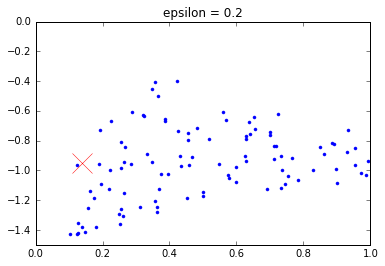

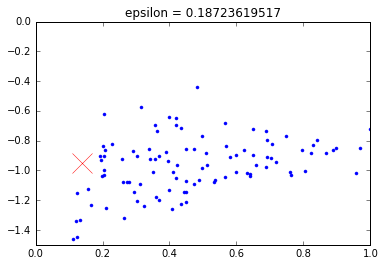

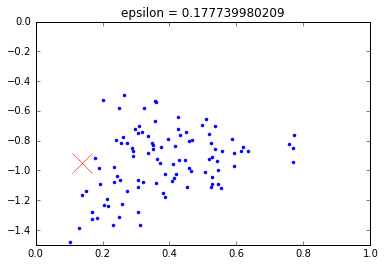

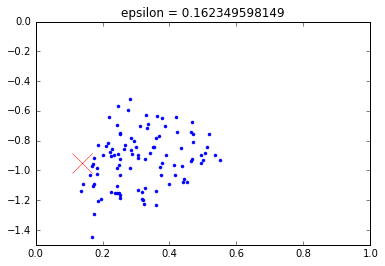

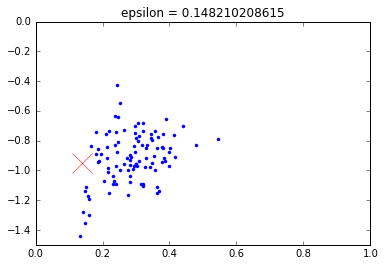

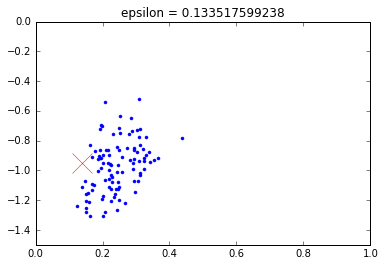

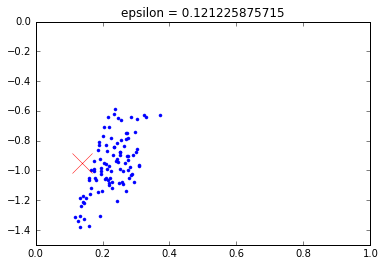

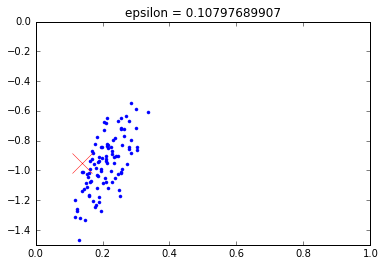

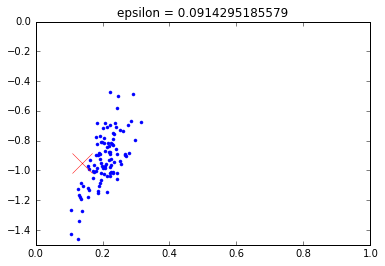

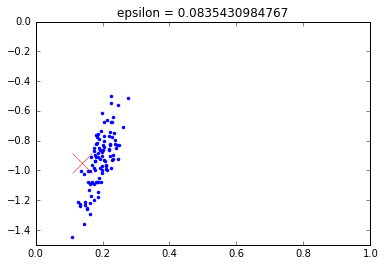

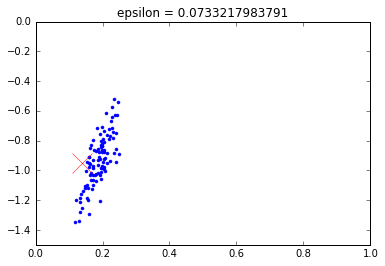

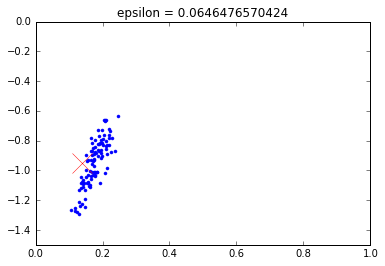

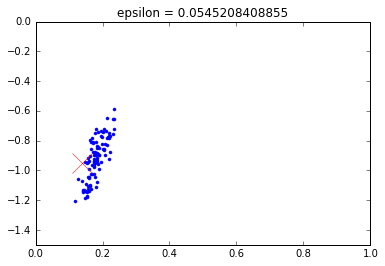

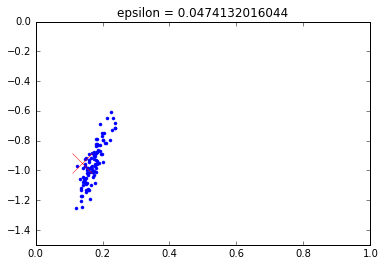

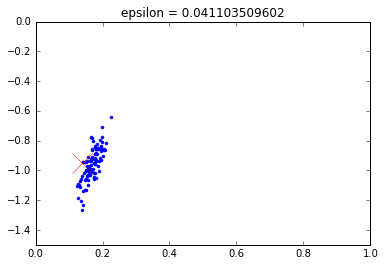

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

i1 = 0
i2 = 1

theta_0 = model.theta_0

for i in range(pmc_posterior.shape[0]):
    plt.figure()
    plt.plot(pmc_posterior[i][0][i1,:], pmc_posterior[i][0][i2,:], '.');
    plt.title('epsilon = {}'.format(pmc_posterior[i]['epsilon']))
    plt.plot(theta_0[i1], theta_0[i2], 'rx', ms=20)
    plt.xlim(*model.bounds[i1])
    plt.ylim(*model.bounds[i2])

In [18]:
type(pmc_posterior)

numpy.ndarray